# Table of Contents
 <p><div class="lev1"><a href="#helper-1">helper</a></div><div class="lev1"><a href="#lmfit-lorentzian-amplitude-2">lmfit lorentzian amplitude</a></div><div class="lev2"><a href="#function-to-fit-using-lmfit-2.1">function to fit using lmfit</a></div><div class="lev2"><a href="#bob-2.2">bob</a></div><div class="lev1"><a href="#loop-over-all-cases-3">loop over all cases</a></div><div class="lev2"><a href="#frequency-fitting-using-lmfit-3.1">frequency fitting using lmfit</a></div><div class="lev1"><a href="#construct-full-model-4">construct full model</a></div><div class="lev2"><a href="#integrate-psi4-amplitude-to-see-if-it-is-strain-amplitude-4.1">integrate psi4 amplitude to see if it is strain amplitude</a></div>

In [ ]:
# this notebook investigates how to better fit the amplitude around the peak
# it uses a 3 or 4 piece ansatz.
# lorenztian + tanh + bob + exp

In [273]:
# env source /Users/sebastian/Desktop/work/git/stk/ml/waveforms/venv-wf/bin/activate

In [1]:
import sys
sys.path.append("../../nonspin/")

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
from waveform import SingleModeNRWaveform

from scipy.interpolate import InterpolatedUnivariateSpline as IUS

import phenom

import lmfit
from lmfit import Minimizer, Parameters, report_fit

In [2]:
matplotlib.rcParams.update({'font.size': 18})

# helper

In [3]:

def mass1_from_mtotal_eta(mtotal, eta):
    """Returns the primary mass from the total mass and symmetric mass
    ratio.
    """
    return 0.5 * mtotal * (1.0 + (1.0 - 4.0 * eta)**0.5)


def mass2_from_mtotal_eta(mtotal, eta):
    """Returns the secondary mass from the total mass and symmetric mass
    ratio.
    """
    return 0.5 * mtotal * (1.0 - (1.0 - 4.0 * eta)**0.5)


In [4]:
class Psi4(object):
    """
    stores Psi4 data aligned such that the peak of Psi4 is at t=0
    """
    def __init__(self, nrfile, ell, mm, npts_time, t1, t2):
        self.nrfile = nrfile
        self.ell = ell
        self.mm = mm
        self.npts_time = npts_time
        self.t1 = t1
        self.t2 = t2
        self.nrdata = SingleModeNRWaveform(self.nrfile, self.ell, self.mm, self.npts_time,t1=self.t1,t2=self.t2)
    
        self.eta = self.nrdata.eta
        self.q = float("{:.3f}".format(self.nrdata.q))
        
        ihlmre = IUS(self.nrdata.times, self.nrdata.hlm.real)
        ihlmim = IUS(self.nrdata.times, self.nrdata.hlm.imag)

        psi4lmre = ihlmre.derivative().derivative()(self.nrdata.times)
        psi4lmim = ihlmim.derivative().derivative()(self.nrdata.times)

        self.psi4lm = psi4lmre - 1.j*psi4lmim
        
        self.psi4lm_amp = np.abs(self.psi4lm)
        
        # index of maximum
        max_idx = self.psi4lm_amp.argmax()
        # time of maximum
        self.time_at_max_idx = self.nrdata.times[max_idx]
        
        self.times = self.nrdata.times - self.time_at_max_idx
        
        
        
        self.psi4lm_phase = np.unwrap(np.angle(self.psi4lm))
        i_psi4lm_phase = IUS(self.times, self.psi4lm_phase)
        self.psi4lm_ang_freq = i_psi4lm_phase.derivative()(self.times)
        
        

        eta, chi1z, chi2z = self.eta, 0., 0.
        self.fin_spin = phenom.remnant.FinalSpin0815(eta, chi1z, chi2z)
        self.fring = phenom.remnant.fring(eta, chi1z, chi2z, self.fin_spin)
        self.fdamp = phenom.remnant.fdamp(eta, chi1z, chi2z, self.fin_spin)
        self.final_mass = 1.0 - phenom.EradRational0815(eta, chi1z, chi2z)
        
#         self.ang_f_22_isco = phenom.HztoMf(f_SchwarzISCO(self.final_mass), self.final_mass)

        m1 = mass1_from_mtotal_eta(1., eta)
        m2 = mass2_from_mtotal_eta(1., eta)
#         self.hyb_meco_ang_freq = phenom.HztoMf(hybrid_meco_frequency(m1, m2, chi1z, chi2z), self.final_mass) * 2 * np.pi

        # get from TaylorT3 orb frequency: https://arxiv.org/abs/0901.2437
#         leading_order = 2
        

# lmfit lorentzian amplitude

In [5]:
# get data
nrfiles = dict(
    q1='/Users/sebastian/Desktop/work/data/SXS_BBH_0071_Res5.h5',
    q2='/Users/sebastian/Desktop/work/data/SXS_BBH_0169_Res5.h5',
    q4='/Users/sebastian/Desktop/work/data/SXS_BBH_0167_Res5.h5',
    q5='/Users/sebastian/Desktop/work/data/SXS_BBH_0107_Res5.h5',
    q10='/Users/sebastian/Desktop/work/data/SXS_BBH_0303_Res5.h5'
)

In [6]:
nrfiles['q1']

'/Users/sebastian/Desktop/work/data/SXS_BBH_0071_Res5.h5'

In [7]:
ell = 2
mm = 2

npts_time = 1000*2
npts_mass_ratio = len(nrfiles)

# t1=None
# t2=None
t1=-600
# t1=-800
t2=80


In [8]:
psi4s = {}
for k,v in nrfiles.iteritems():
    psi4s.update({k:Psi4(v, ell, mm, npts_time,t1=t1,t2=t2)})

../../nonspin/waveform.py:23: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  amp_x = amp_tmp['X'].value
../../nonspin/waveform.py:24: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  amp_y = amp_tmp['Y'].value
../../nonspin/waveform.py:27: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  phase_x = phase_tmp['X'].value
../../nonspin/waveform.py:28: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  phase_y = phase_tmp['Y'].value


In [9]:
for k in psi4s.keys():
    print(1./psi4s[k].fdamp/2/np.pi)

11.706422641558191
11.554740530290251
11.32930696199893
11.272552160962043
11.36516841490208


Text(0.5,1,'$|\\Psi_4|(t)$')

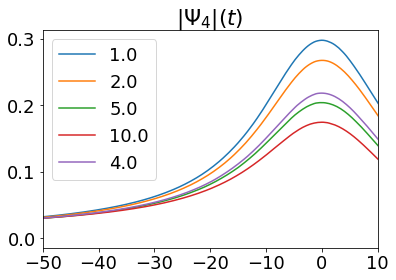

In [10]:
plt.figure()
for k in psi4s.keys():
    plt.plot(psi4s[k].times, psi4s[k].psi4lm_amp / psi4s[k].eta, label=psi4s[k].q)
plt.legend()
plt.xlim(-50,10)
# plt.yscale('log')
plt.title(r'$|\Psi_4|(t)$')

Text(0.5,1,'$\\omega_{gw}(t)$')

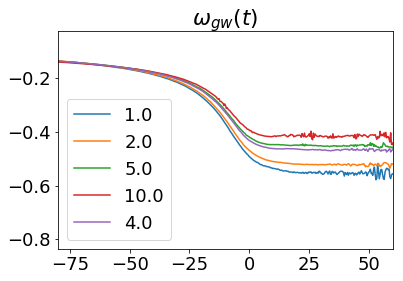

In [11]:
plt.figure()
for k in psi4s.keys():
    plt.plot(psi4s[k].times, psi4s[k].psi4lm_ang_freq, label=psi4s[k].q)
plt.legend()
plt.xlim(-80,60)
# plt.yscale('log')
plt.title(r'$\omega_{gw}(t)$')

## function to fit using lmfit

In [85]:
class Model(object):
    def __init__(self, Psi4):
        """
        input: Psi4 object
        """
        self.Psi4 = Psi4
        
    def model_amp_ramp_up(self, params, t):
        
        tdamp = params['tdamp']
        tp = params['tp']
        lor_amp = params['lor_amp']
        a0 = params['a0']
        a1 = params['a1']
        
#         a2 = params['a2']
        
        model = (lor_amp * tdamp) / ( (t-tp)**2 + tdamp**2 ) + a0 / (t - tp) + a1 / (t - tp)**2
#         model +=+ a2 / (t - tp)**4
        
#         a_tdamp = params['a_tdamp']
#         a_tp = params['a_tp']
#         a_ap = params['a_ap']
        
#         sech = 1/np.cosh( (a_tp - t) / a_tdamp )
#         model += a_ap * sech
        
        
        return model
    
    def model_amp_ramp_up_to_min(self, params, t, data):
        model = self.model_amp_ramp_up(params, t)
        return model - data
        
    def fit_amp_ramp_up(self, fix_tdamp, t1=-200, t2=0):
        """
        fix_tdamp = True or False. If True then use theoretical damping time
        """
        self.model_amp_ramp_up_mask = (self.Psi4.times > t1) & (self.Psi4.times < t2)
        self.fit_times = self.Psi4.times[self.model_amp_ramp_up_mask]
        self.fit_data = self.Psi4.psi4lm_amp[self.model_amp_ramp_up_mask]
        
        # create a set of Parameters
        params = Parameters()
        
        if fix_tdamp:
            params.add('tdamp', value=1./self.Psi4.fdamp/2/np.pi, vary=False)
        else:
            params.add('tdamp', value=20., min=1, max=200)
        
        params.add('tp', value=20, min=-100, max=200)
        params.add('lor_amp', value=0., min=-2000, max=2000)
        params.add('a0', value=0., min=-2000, max=2000)
        params.add('a1', value=0., min=-2000, max=8000)
        
#         params.add('a2', value=100., min=-800000, max=400000)
        
        
#         params.add('a_tdamp', value=20., min=1, max=200)
#         params.add('a_tp', value=0, min=-100, max=200)
#         params.add('a_ap', value=0., min=-2000, max=2000)
        
        fcn2min = self.model_amp_ramp_up_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times, self.fit_data))
        
        self.amp_ramp_up_result = minner.minimize()

        # calculate final result
        self.amp_ramp_up_final = self.fit_data + self.amp_ramp_up_result.residual

        # write error report
        report_fit(self.amp_ramp_up_result)
        
        
        
    def model_amp_bob(self, params, t):
        
        tdamp = params['tdamp']
        tp = params['tp']
        ap = params['ap']
        
#         tdamp_vary = params['tdamp_vary']
#         t1 = tdamp/4
#         t2 = t1 + 10
#         t1 = 15
#         t2 = t1 + 20
#         trans = self.planck_taper(t, t1, t2)
        
#         vary_damp =  (1. - trans) * tdamp_vary + trans * tdamp
#         vary_damp = tdamp
        
#         sech = 1/np.cosh( (tp - t) / tdamp )
#         sech = 1/np.cosh( (tp - t) / vary_damp )
#         sech = 1/np.cosh( (tp - t) / vary_damp + (params['b']*(tp - t) / vary_damp)**2 )

        sech = 1/np.cosh( (tp - t) / tdamp )
        model = ap * sech

        return model
    
    def model_amp_bob_to_min(self, params, t, data):
        model = self.model_amp_bob(params, t)
        return model - data
        
    def fit_amp_bob(self, fix_tdamp, t1=-20, t2=20):
        """
        fix_tdamp = True or False. If True then use theoretical damping time
        """
        self.model_amp_bob_mask = (self.Psi4.times > t1) & (self.Psi4.times < t2)
        self.fit_times_bob = self.Psi4.times[self.model_amp_bob_mask]
        self.fit_data_bob = self.Psi4.psi4lm_amp[self.model_amp_bob_mask]
        
        # create a set of Parameters
        params = Parameters()
        
        if fix_tdamp:
            params.add('tdamp', value=1./self.Psi4.fdamp/2/np.pi, vary=False)
        else:
            params.add('tdamp', value=20., min=1, max=200)
        
        params.add('tp', value=0, min=-100, max=200)
        params.add('ap', value=0., min=-2000, max=2000)
        
#         params.add('tdamp_vary', value=20., min=1, max=200)
#         params.add('b', value=0., min=-2000, max=2000)
        
        
        fcn2min = self.model_amp_bob_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times_bob, self.fit_data_bob))
        
        self.amp_bob_result = minner.minimize()

        # calculate final result
        self.amp_bob_final = self.fit_data_bob + self.amp_bob_result.residual

        # write error report
        report_fit(self.amp_bob_result)
        
        
        
    def model_freq_mr(self, params, t):
        t0 = params['t0']
        kappa = params['kappa']
        b = params['b']
        ap = params['ap']
        offset = params['offset']

        dt = t - t0
#         num = 1. + np.tanh(np.log(np.sqrt(kappa)) - (dt/b))
        num = 1. + np.tanh((dt/b))
        den = 2.

        model = offset + (ap - offset) * (num/den)**kappa
        
        
        return model
    
    def model_freq_mr_to_min(self, params, t, data):
        model = self.model_freq_mr(params, t)
        return model - data
        
    def fit_freq_mr(self, t1=-40, t2=0):
        self.model_freq_mr_mask = (self.Psi4.times > t1) & (self.Psi4.times < t2)
        self.fit_times_mr = self.Psi4.times[self.model_freq_mr_mask]
        self.fit_data_mr = self.Psi4.psi4lm_amp[self.model_freq_mr_mask]
        
        # create a set of Parameters
        params = Parameters()
        
        params.add('t0', value=5., min=-40, max=40)
#         params.add('t0', value=tp_amp, vary=False)
        params.add('kappa', value=1, min=1e-9, max=10, vary=False)
#         params.add('kappa', value=1, vary=False)
        # params.add('kappa', value=0.25, vary=False) # bob value?
#         params.add('kappa', value=0.36, vary=False) # best fit value?
        params.add('b', value=1., min=-2000, max=2000)
#         params.add('b', value=10., vary=False)
        # fixing b is ok but fitting is better
#         params.add('b', value=1./self.Psi4.fdamp/2/np.pi, vary=False)
        params.add('ap', value=1, min=1e-4, max=1e2)
        params.add('offset', value=0., min=-200, max=200)
        
        fcn2min = self.model_freq_mr_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(self.fit_times_mr, self.fit_data_mr))
        
#         self.freq_mr_result = minner.minimize(method='differential_evolution')
        self.freq_mr_result = minner.minimize()

        # calculate final result
        self.freq_mr_final = self.fit_data_mr + self.freq_mr_result.residual

        # write error report
        report_fit(self.freq_mr_result)
        
        
    def planck_taper(self, times, t1, t2):
        """times: array of times
        t1. for t<=t1 then return 0
        t2. for t>=t2 then return 1
        else return 1./(np.exp((t2-t1)/(t-t1)+(t2-t1)/(t-t2))+1)"""
        tout = []
        for t in times:
            if t<=t1:
                tout.append(0.)
            elif t>=t2:
                tout.append(1.)
            else:
                tout.append(1./(np.exp((t2-t1)/(t-t1)+(t2-t1)/(t-t2))+1))
        return np.array(tout)
        
    def amp_model(self, times, t0 = -10, sigma=10):
        
        self.ramp_up = self.model_amp_ramp_up(self.amp_ramp_up_result.params, times)
        self.bob = self.model_amp_bob(self.amp_bob_result.params,times)
        
        t1 = t0 - sigma/2.
        t2 = t0 + sigma/2.
        self.trans = self.planck_taper(times, t1, t2)
        
        return (1. - self.trans) * self.ramp_up + self.trans * self.bob
        
    def compare_model_with_data(self, t0=-10, sigma=10):
        self.t_data, self.y_data = self.Psi4.times, self.Psi4.psi4lm_amp
        self.y_model = self.amp_model(self.t_data, t0=t0, sigma=sigma)

In [86]:
q1_fit = Model(psi4s['q10'])
q1_fit.fit_amp_ramp_up(fix_tdamp=False, t1=-800, t2=-10)
# q1_fit.fit_amp_bob(fix_tdamp=False, t1=-10, t2=20)
q1_fit.fit_amp_bob(fix_tdamp=False, t1=-3, t2=20)

q1_fit.fit_freq_mr()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 12001
    # data points      = 1758
    # variables        = 5
    chi-square         = 4.2024e-07
    reduced chi-square = 2.3973e-10
    Akaike info crit   = -38937.3929
    Bayesian info crit = -38910.0332
##  Warning: uncertainties could not be estimated:
[[Variables]]
    tdamp:    6.80873416 (init = 20)
    tp:       46.4887991 (init = 20)
    lor_amp: -302.539931 (init = 0)
    a0:      -0.23170958 (init = 0)
    a1:       2050.40215 (init = 0)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 39
    # data points      = 67
    # variables        = 3
    chi-square         = 2.5483e-08
    reduced chi-square = 3.9818e-10
    Akaike info crit   = -1447.22555
    Bayesian info crit = -1440.61148
[[Variables]]
    tdamp:  10.7553606 +/- 0.01119236 (0.10%) (init = 20)
    tp:     0.04036083 +/- 0.01319990 (32.70%) (init = 0)
    ap:     0.01443794 +/- 4.4962e-06 (0.03%) (init = 0)

In [105]:
q1_fit_fix_tdamp = Model(psi4s['q10'])
q1_fit_fix_tdamp.fit_amp_ramp_up(fix_tdamp=True, t1=-800, t2=-20)
# q1_fit_fix_tdamp.fit_amp_bob(fix_tdamp=True, t1=-10, t2=20)
# q1_fit_fix_tdamp.fit_amp_bob(fix_tdamp=True, t1=-5, t2=20)
q1_fit_fix_tdamp.fit_amp_bob(fix_tdamp=False, t1=-10, t2=10)

q1_fit_fix_tdamp.fit_freq_mr(t1=-20, t2=-5)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 143
    # data points      = 1729
    # variables        = 4
    chi-square         = 2.8478e-07
    reduced chi-square = 1.6509e-10
    Akaike info crit   = -38940.9427
    Bayesian info crit = -38919.1215
[[Variables]]
    tdamp:    11.27255 (fixed)
    tp:       51.7256233 +/- 0.22645130 (0.44%) (init = 20)
    lor_amp: -92.8557571 +/- 1.28808916 (1.39%) (init = 0)
    a0:      -0.23867478 +/- 4.3472e-04 (0.18%) (init = 0)
    a1:       1035.56379 +/- 14.4273058 (1.39%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(lor_amp, a1) = -1.000
    C(tp, a1)      =  0.991
    C(tp, lor_amp) = -0.990
    C(lor_amp, a0) =  0.862
    C(a0, a1)      = -0.861
    C(tp, a0)      = -0.806
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 59
    # variables        = 3
    chi-square         = 1.1268e-07
    reduced chi-square = 2.0122e-09
    

(-80, 20)

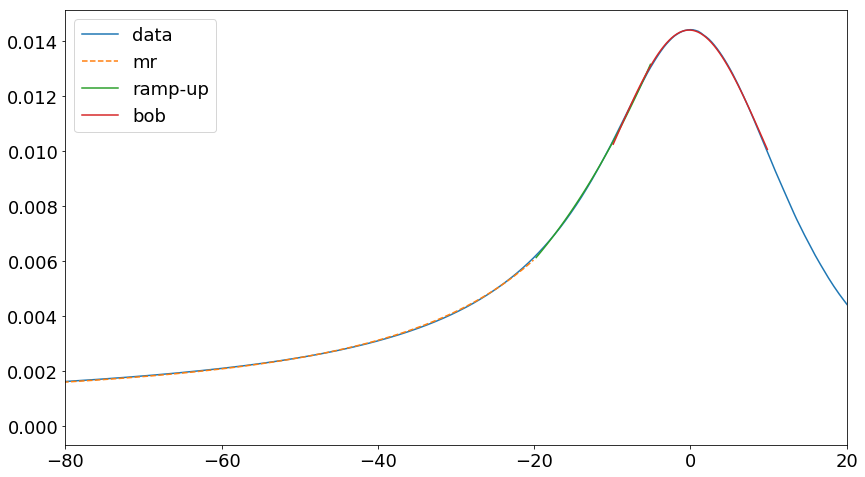

In [109]:
plt.figure(figsize=(14,8))
plt.plot(q1_fit.Psi4.times, q1_fit.Psi4.psi4lm_amp, label='data')

# plt.plot(q1_fit.Psi4.times, q1_fit.model_amp_ramp_up(q1_fit.amp_ramp_up_result.params,q1_fit.Psi4.times), label='vary')
# plt.plot(q1_fit_fix_tdamp.Psi4.times, q1_fit_fix_tdamp.model_amp_ramp_up(q1_fit_fix_tdamp.amp_ramp_up_result.params,q1_fit_fix_tdamp.Psi4.times), label='fix')


plt.plot(q1_fit_fix_tdamp.fit_times, q1_fit_fix_tdamp.amp_ramp_up_final, label='mr', ls='--')

plt.plot(q1_fit_fix_tdamp.fit_times_mr, q1_fit_fix_tdamp.freq_mr_final, label='ramp-up')

plt.plot(q1_fit_fix_tdamp.fit_times_bob, q1_fit_fix_tdamp.amp_bob_final, label='bob')


plt.legend()
# plt.xlim(-80,5)
plt.xlim(-80,20)
# plt.xlim(-20,20)
# plt.xlim(-20,60)
# plt.xlim(-10,10)
# plt.ylim(0.06,0.08)
# plt.yscale('log')
